In [29]:
pip install hdbscan

     ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
     - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/6.9 MB 2.6 MB/s eta 0:00:03
     ------ --------------------------------- 1.0/6.9 MB 2.6 MB/s eta 0:00:03
     ------------ --------------------------- 2.1/6.9 MB 2.7 MB/s eta 0:00:02
     --------------- ------------------------ 2.6/6.9 MB 2.7 MB/s eta 0:00:02
     ------------------ --------------------- 3.1/6.9 MB 2.7 MB/s eta 0:00:02
     ---------------------- ----------------- 3.9/6.9 MB 2.7 MB/s eta 0:00:02
     ------------------------- -------------- 4.5/6.9 MB 2.7 MB/s eta 0:00:01
     ---------------------------- ----------- 5.0/6.9 MB 2.7 MB/s eta 0:00:01
     --------------------------------- ------ 5.8/6.9 MB 2.7 MB/s eta 0:00:01
     --------------------------------- ------ 5.8/6.9 MB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 6.9/6.9 MB 2.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install umap-learn


In [ ]:
!pip install --upgrade numpy scikit-learn  # Ensure compatibility


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


CODE 1

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# --- Data Loading & Cleaning ---
df = (
    pd.read_csv('C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv',
                parse_dates=['Timestamp'])
    .rename(columns={
        'Electricity_Demand_MWh': 'energy_kWh',
        'temperature': 'temperature_C',
        'windSpeed': 'wind_speed'
    })
    .dropna(subset=['energy_kWh', 'temperature_C', 'humidity', 'wind_speed', 'pressure'])
)

# --- Feature Engineering ---
df = df.assign(
    hour = df['Timestamp'].dt.hour,
    month = df['Timestamp'].dt.month,
    hour_sin = np.sin(2 * np.pi * df['Timestamp'].dt.hour/24),
    hour_cos = np.cos(2 * np.pi * df['Timestamp'].dt.hour/24)
)

# --- Outlier Removal ---
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df[['energy_kWh', 'temperature_C']])
df = df[outliers == 1]

# --- Feature Scaling ---
features = [
    'temperature_C', 'humidity', 'wind_speed', 'pressure',
    'energy_kWh', 'month', 'hour_sin', 'hour_cos'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# --- Dimensionality Reduction ---
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA: {pca.n_components_} components ({pca.explained_variance_ratio_.sum():.1%} variance)")



PCA: 6 components (87.7% variance)


CODE 2 

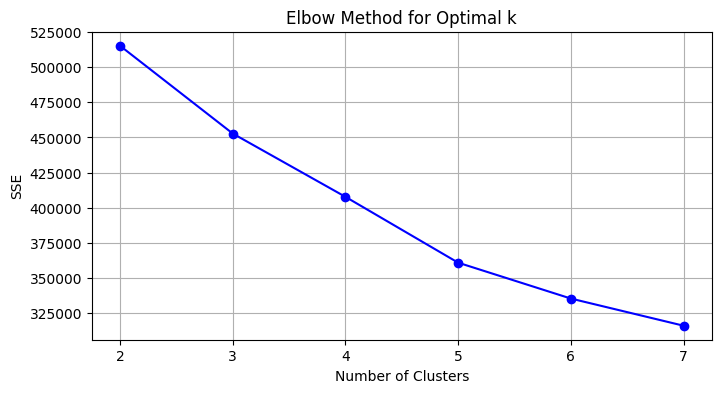

c:\Users\SLS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SLS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\SLS\AppData\Local\Temp\ipykernel_6304\301831465.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(100, len(x)), replace=False))



=== Silhouette Scores ===
K-Means: 0.170
HDBSCAN: 0.212 (Noise: 3.6%)

=== Cluster Characteristics ===
                energy_kWh_mean  energy_kWh_std  temperature_C_mean  \
kmeans_cluster                                                        
0                      38464.30        30847.91               58.59   
1                      29675.94        29355.06               58.03   
2                      16031.00        16940.27               75.57   
3                      22939.62        25659.74               47.60   

                hour_mean City_mode                         label  
kmeans_cluster                                                     
0                   13.81       nyc     High-demand Hot Afternoon  
1                    9.77   seattle                 Normal Demand  
2                   12.69   phoenix  Temperature-Sensitive Period  
3                   10.49   seattle                 Normal Demand  


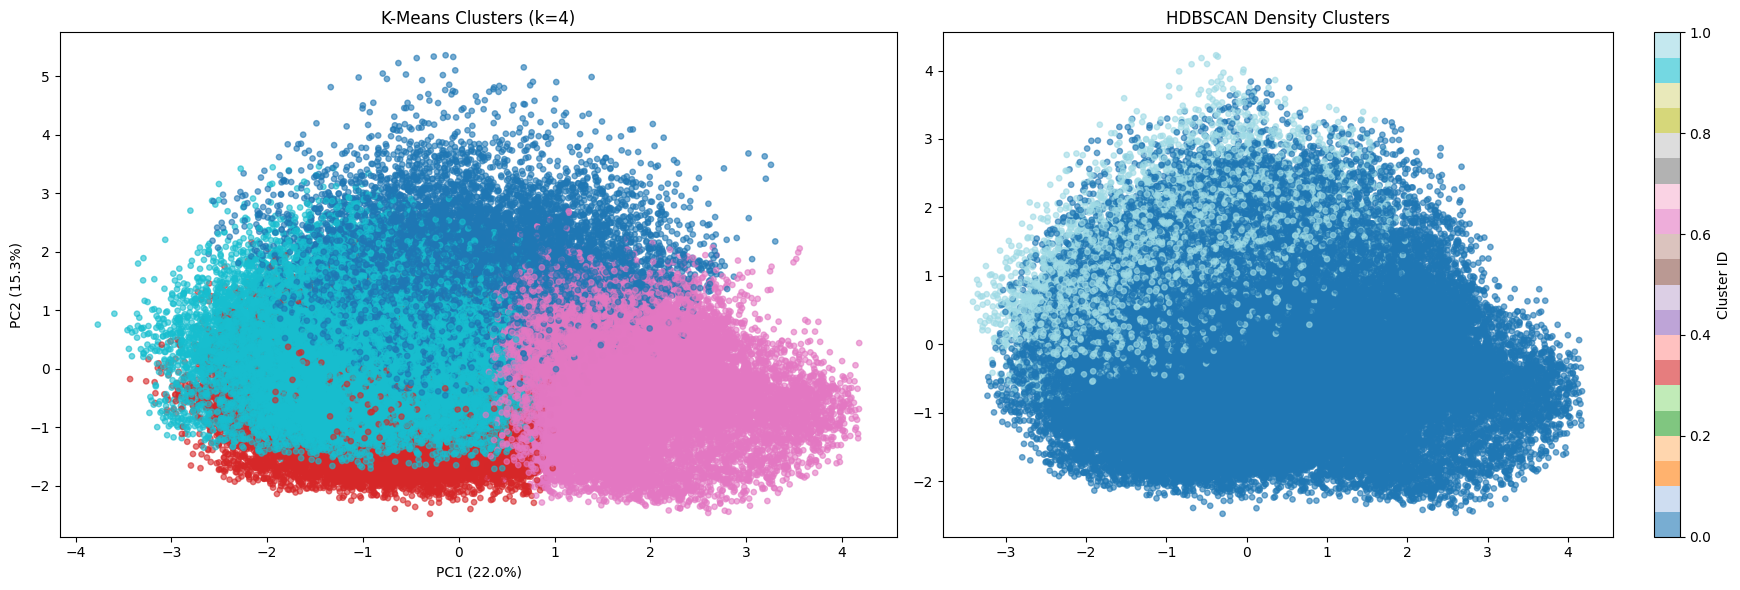

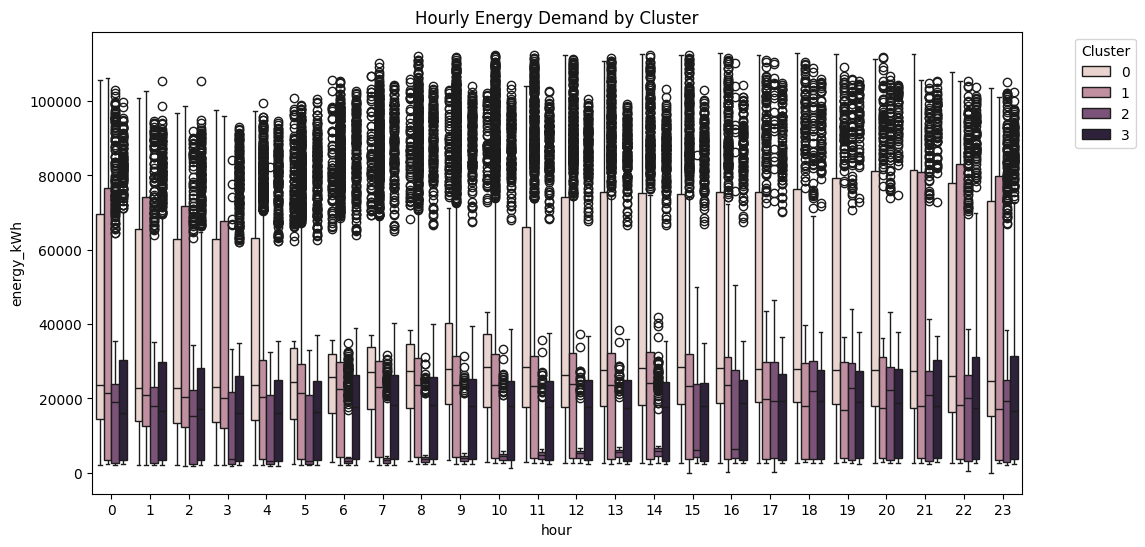

In [39]:
# === CLUSTERING IMPLEMENTATION ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import hdbscan
import matplotlib.pyplot as plt
import numpy as np

# --- K-Means Clustering ---
# Elbow Method visualization
sse = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

# Final K-Means clustering
optimal_k = 4  # Set based on elbow plot analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_pca)

# --- Density-Based Clustering (HDBSCAN) ---
hdb = hdbscan.HDBSCAN(
    min_cluster_size=500,
    min_samples=30,
    cluster_selection_epsilon=3.0,
    memory='./cache'
)
df['hdbscan_cluster'] = hdb.fit_predict(X_pca)

# --- Hierarchical Clustering (Fixed Version) ---
# Create fresh numeric indices
df = df.reset_index(drop=True)

# Stratified sampling with index preservation
strat_sample = (
    df.groupby(['City', 'hour'], group_keys=False)
    .apply(lambda x: x.sample(n=min(100, len(x)), replace=False))
    .reset_index(drop=True)
)

# Create linkage matrix using standardized features
Z = linkage(scaler.transform(strat_sample[features]), 
            method='ward', 
            metric='euclidean')

# Apply clusters using valid indices
df['hierarchical_cluster'] = np.nan
df.loc[strat_sample.index, 'hierarchical_cluster'] = fcluster(Z, t=3.0, criterion='distance')

# Drop temporary index if needed
df = df.drop(columns=['index'], errors='ignore')

# === CLUSTER EVALUATION ===
print("\n=== Silhouette Scores ===")
print(f"K-Means: {silhouette_score(X_pca, df['kmeans_cluster']):.3f}")

hdb_labels = df['hdbscan_cluster']
valid_hdb = hdb_labels[hdb_labels != -1]
if len(valid_hdb) > 1:
    print(f"HDBSCAN: {silhouette_score(X_pca[valid_hdb.index], valid_hdb.values):.3f} (Noise: {(hdb_labels == -1).mean():.1%})")

# === CLUSTER INTERPRETATION ===
def label_clusters(row):
    conditions = [
        (row['energy_kWh_mean'] > 25000) & (row['hour_mean'] >= 12),
        (row['energy_kWh_mean'] < 15000) & (row['hour_mean'] <= 5),
        (row['temperature_C_mean'] > df['temperature_C'].quantile(0.75))
    ]
    choices = [
        'High-demand Hot Afternoon',
        'Low-demand Cool Night', 
        'Temperature-Sensitive Period'
    ]
    return np.select(conditions, choices, default='Normal Demand')

cluster_profile = df.groupby('kmeans_cluster').agg({
    'energy_kWh': ['mean', 'std'],
    'temperature_C': 'mean',
    'hour': 'mean',
    'City': lambda x: x.mode()[0]
}).round(2)

cluster_profile.columns = ['energy_kWh_mean', 'energy_kWh_std', 
                          'temperature_C_mean', 'hour_mean', 'City_mode']
cluster_profile['label'] = cluster_profile.apply(label_clusters, axis=1)

print("\n=== Cluster Characteristics ===")
print(cluster_profile)

# === VISUALIZATION ===
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# K-Means clusters
sc1 = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                  c=df['kmeans_cluster'], cmap='tab10', 
                  alpha=0.6, s=15)
ax[0].set_title(f'K-Means Clusters (k={optimal_k})')
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# HDBSCAN clusters
hdbscan_plot = df[df['hdbscan_cluster'] != -1]
sc2 = ax[1].scatter(X_pca[hdbscan_plot.index, 0], X_pca[hdbscan_plot.index, 1],
                  c=hdbscan_plot['hdbscan_cluster'], cmap='tab20',
                  alpha=0.6, s=15)
ax[1].set_title('HDBSCAN Density Clusters')
plt.colorbar(sc2, ax=ax[1], label='Cluster ID')

plt.tight_layout()
plt.show()

# Temporal Pattern Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='energy_kWh', hue='kmeans_cluster', data=df)
plt.title('Hourly Energy Demand by Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.show()

CODE 3 

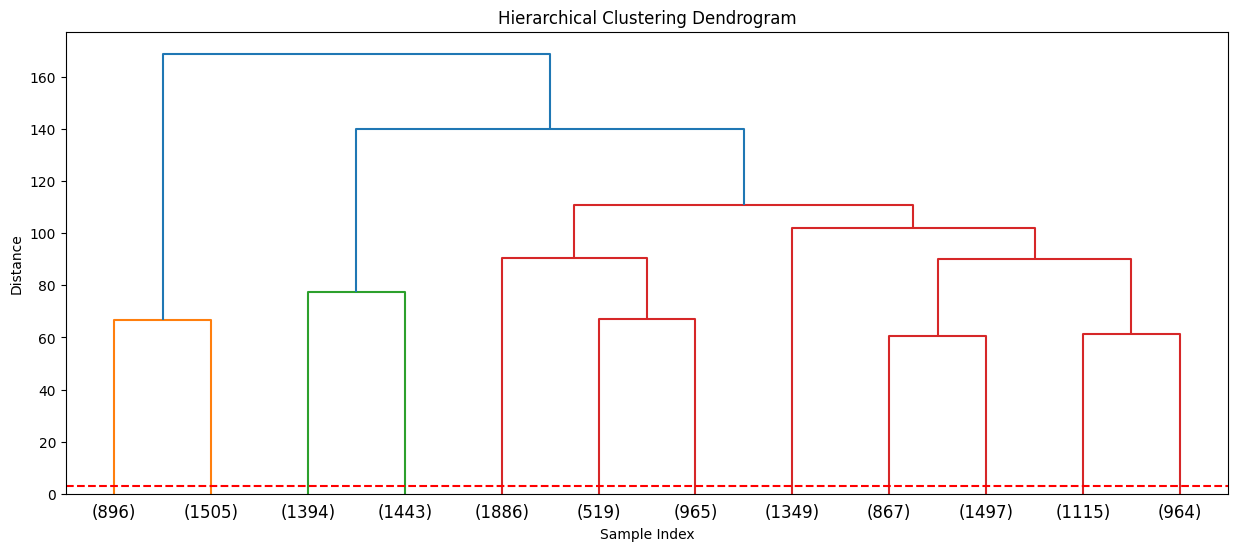

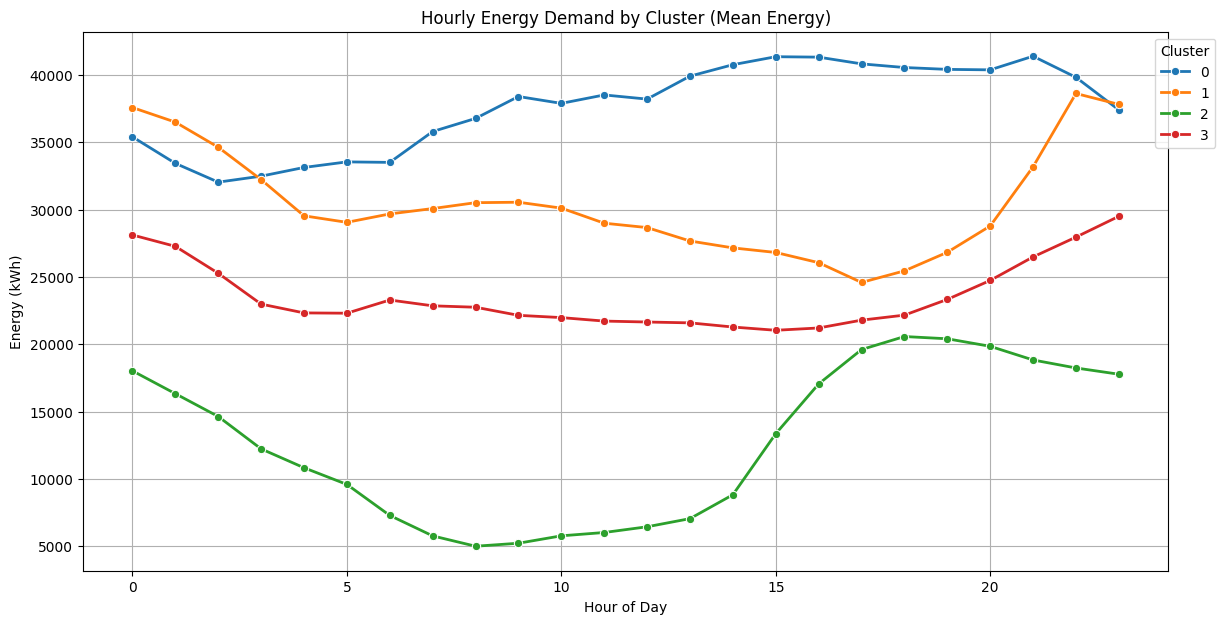

In [ ]:
# --- Hierarchical Clustering with Dendrogram ---
# Create linkage matrix (use standardized features)
Z = linkage(scaler.transform(strat_sample[features]), 
            method='ward', 
            metric='euclidean')

# Plot dendrogram (ADD THIS SECTION)
plt.figure(figsize=(15, 6))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=3.0, color='r', linestyle='--')  # Cut-off line for clusters
plt.show()

# Apply clusters to sampled data
strat_clusters = fcluster(Z, t=3.0, criterion='distance')

# Propagate hierarchical clusters back to original dataframe
df['hierarchical_cluster'] = np.nan
df.loc[strat_sample.index, 'hierarchical_cluster'] = strat_clusters

# === FIXED HOURLY ENERGY PLOT ===
plt.figure(figsize=(14, 7))

# Calculate mean energy per hour per cluster
hourly_energy = df.groupby(['hour', 'kmeans_cluster'])['energy_kWh'].mean().reset_index()

# Line plot with clusters
sns.lineplot(
    data=hourly_energy,
    x='hour',
    y='energy_kWh',
    hue='kmeans_cluster',
    palette='tab10',
    marker='o',
    linewidth=2
)

plt.title('Hourly Energy Demand by Cluster (Mean Energy)')
plt.xlabel('Hour of Day')
plt.ylabel('Energy (kWh)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

# ... [Rest of your existing code for evaluation] ...

<Figure size 1400x1000 with 0 Axes>

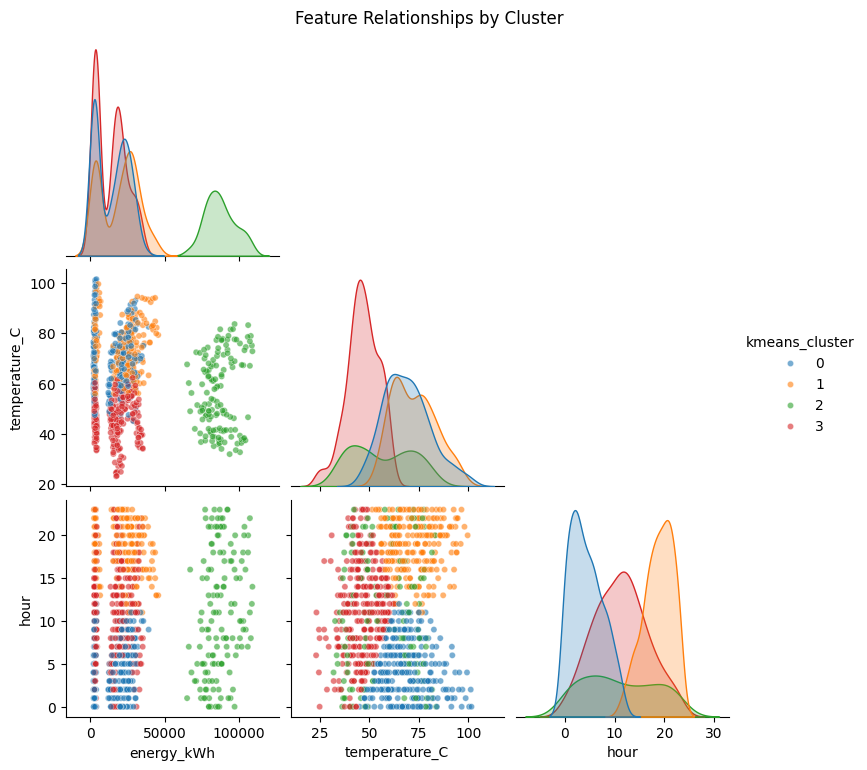

In [44]:
# === CELL 4: ADDITIONAL CLUSTER VISUALIZATIONS ===

# 1. Pair Plot of Features Colored by Clusters
plt.figure(figsize=(14, 10))
pair_grid = sns.pairplot(
    data=df.sample(1000) if len(df) > 1000 else df,  # Subsample for large datasets
    vars=['energy_kWh', 'temperature_C', 'hour'],
    hue='kmeans_cluster',
    palette='tab10',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 20}
)
pair_grid.fig.suptitle('Feature Relationships by Cluster', y=1.02)
plt.show()

